In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.stats.api as sms
from scipy.stats import ttest_1samp, shapiro, levene, ttest_ind, mannwhitneyu, pearsonr, spearmanr, kendalltau, f_oneway, kruskal
from statsmodels.stats.proportion import proportions_ztest

In [3]:
data = pd.read_csv('marketing_AB.csv')

<ipython-input-3-7442639a616e>:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('marketing_AB.csv')


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392403 entries, 0 to 392402
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Unnamed: 0     392403 non-null  int64  
 1   user id        392403 non-null  int64  
 2   test group     392402 non-null  object 
 3   converted      392402 non-null  object 
 4   total ads      392402 non-null  float64
 5   most ads day   392402 non-null  object 
 6   most ads hour  392402 non-null  float64
dtypes: float64(2), int64(2), object(3)
memory usage: 21.0+ MB


In [5]:
data.head()

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
0,0,1069124,ad,False,130.0,Monday,20.0
1,1,1119715,ad,False,93.0,Tuesday,22.0
2,2,1144181,ad,False,21.0,Tuesday,18.0
3,3,1435133,ad,False,355.0,Tuesday,10.0
4,4,1015700,ad,False,276.0,Friday,14.0


In [6]:
data.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392403 entries, 0 to 392402
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   user id        392403 non-null  int64  
 1   test group     392402 non-null  object 
 2   converted      392402 non-null  object 
 3   total ads      392402 non-null  float64
 4   most ads day   392402 non-null  object 
 5   most ads hour  392402 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 18.0+ MB


In [8]:
data.isna().sum()

user id          0
test group       1
converted        1
total ads        1
most ads day     1
most ads hour    1
dtype: int64

In [9]:
data.duplicated().sum()

0

In [10]:
modified_columns = [column.replace(' ', '_') for column in data.columns]

In [11]:
data.columns = modified_columns

In [12]:
data.shape

(392403, 6)

In [13]:
data['test_group'].value_counts(normalize = True) * 100

test_group
ad     96.396298
psa     3.603702
Name: proportion, dtype: float64

In [14]:
data.groupby(['test_group'])['converted'].value_counts()

test_group  converted
ad          False        365452
            True          12809
psa         False         13805
            True            336
Name: count, dtype: int64

In [15]:
# converted = True means after watching the ad they bought the product
# converted = False means after watching the ad they did not buy the product

In [16]:
group_ads = data[data['test_group'] == 'ad']
group_psa = data[data['test_group'] == 'psa']

In [17]:
# population means
ads_population_mean = group_ads['converted'].mean()
psa_population_mean = group_psa['converted'].mean()
print(f"ads_population_mean {ads_population_mean}")
print(f"psa_population_mean {psa_population_mean}")

ads_population_mean 0.033862861886369465
psa_population_mean 0.023760695848949864


In [18]:
sampling_ads = []
sampling_psa = []
for _ in range(10000):
  sampling_ads.append(group_ads['converted'].sample(n = 5000, replace = True).mean())
  sampling_psa.append(group_psa['converted'].sample(n = 5000, replace = True).mean())

In [19]:
print(f"sampling ads mean {np.array(sampling_ads).mean()}")
print(f"sampling psa mean {np.array(sampling_psa).mean()}")

sampling ads mean 0.03383358
sampling psa mean 0.023775639999999997


Text(0.5, 1.0, 'sampling distribution of psa')

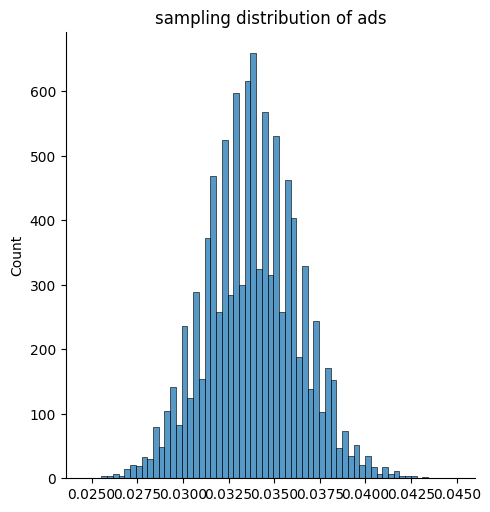

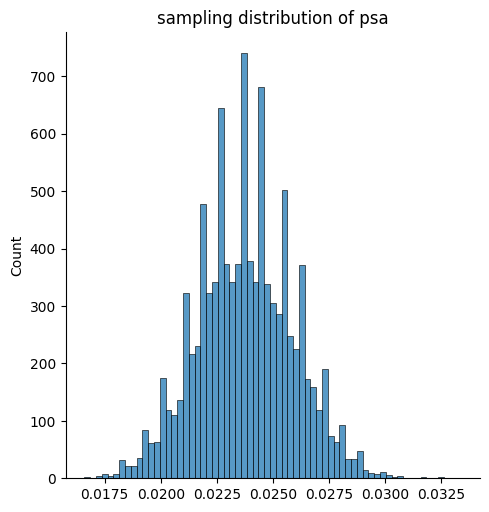

In [20]:
sns.displot(sampling_ads)
plt.title('sampling distribution of ads')
sns.displot(sampling_psa)
plt.title('sampling distribution of psa')

In [21]:
# we can see that central limit theorem which states that even if population does not follow normal distribution,
# if we do sufficient sampling with each sample of considerable size then sampling distribution will follow
# a normal distribution

In [22]:
# Null hypothesis H0 = Advertisements do not have an effect on increasing product purchases
# Alternate hypothesis Ha = Advertisements do have an effect increasing porduct purchases

In [23]:
t_statistic, p_value = stats.ttest_ind(sampling_ads, sampling_psa, equal_var = False)
print(f"p_value is: {p_value}")
if p_value < 0.05:
  print("Rejecting the null hypothesis, advertisements do have an effect increasing product purchases")
else:
  print("Accepting the null hypothesis, advertisements do not have effect on increasing product purchases")

p_value is: 0.0
Rejecting the null hypothesis, advertisements do have an effect increasing product purchases


In [24]:
feature_data = pd.read_csv('feature_a_b_testing.csv')

In [25]:
feature_data.head()

,RecordID,IP Address,LoggedInFlag,ServerID,VisitPageFlag
0,1,39.13.114.2,1,2,0
1,2,13.3.25.8,1,1,0
2,3,247.8.211.8,1,1,0
3,4,124.8.220.3,0,3,0
4,5,60.10.192.7,0,2,0


In [26]:
feature_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184588 entries, 0 to 184587
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   RecordID       184588 non-null  int64 
 1   IP Address     184588 non-null  object
 2   LoggedInFlag   184588 non-null  int64 
 3   ServerID       184588 non-null  int64 
 4   VisitPageFlag  184588 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 7.0+ MB


In [27]:
feature_data = feature_data.groupby(['IP Address', 'LoggedInFlag', 'ServerID'])['VisitPageFlag'].sum()

In [28]:
feature_data = feature_data.reset_index(name = 'VisitPageFlagSum')

In [29]:
feature_data['VisitPageFlag'] = feature_data['VisitPageFlagSum'].apply(lambda x: 1 if x!=0 else 0)

In [30]:
feature_data

,IP Address,LoggedInFlag,ServerID,VisitPageFlagSum,VisitPageFlag
0,0.0.108.2,0,1,0,0
1,0.0.109.6,1,1,0,0
2,0.0.111.8,0,3,0,0
3,0.0.160.9,1,2,0,0
4,0.0.163.1,0,2,0,0
...,...,...,...,...,...
99758,99.9.53.7,1,2,0,0
99759,99.9.65.2,0,2,0,0
99760,99.9.79.6,1,2,0,0
99761,99.9.86.3,0,1,1,1


In [31]:
feature_data['group'] = feature_data['ServerID'].map({1: 'Test', 2: 'Control', 3: 'Control'})

In [32]:
feature_data.drop(['ServerID'], axis = 1, inplace = True)

In [33]:
feature_data.drop(['VisitPageFlagSum'], axis = 1, inplace = True)

In [34]:
feature_data

,IP Address,LoggedInFlag,VisitPageFlag,group
0,0.0.108.2,0,0,Test
1,0.0.109.6,1,0,Test
2,0.0.111.8,0,0,Control
3,0.0.160.9,1,0,Control
4,0.0.163.1,0,0,Control
...,...,...,...,...
99758,99.9.53.7,1,0,Control
99759,99.9.65.2,0,0,Control
99760,99.9.79.6,1,0,Control
99761,99.9.86.3,0,1,Test


In [35]:
control_group = feature_data[feature_data['group'] == 'Control']
test_group = feature_data[feature_data['group'] == 'Test']

In [38]:
test_sum_visit = test_group['VisitPageFlag'].count()
print("Sum visit for test group: ", test_sum_visit)
test_visit_1 = test_group[test_group['VisitPageFlag'] == 1]['VisitPageFlag'].count()
print("Visit Page target = 1 : ", test_visit_1)

Sum visit for test group:  33303
Visit Page target = 1 :  3847


In [39]:
control_sum_visit = control_group['VisitPageFlag'].count()
print("Sum visit for control group: ", control_sum_visit)
control_visit_1 = control_group[control_group['VisitPageFlag'] ==1]['VisitPageFlag'].count()
print("Visit Page target = 1 : ", control_visit_1)

Sum visit for control group:  66460
Visit Page target = 1 :  6131


In [40]:
print(test_visit_1/test_sum_visit)

0.11551511875806984


In [41]:
print(control_visit_1/control_sum_visit)

0.09225097803189888


In [47]:
test_stat, pvalue_control_group = shapiro(control_group["VisitPageFlag"])
print(f"p value is {pvalue_control_group}")

p value is 0.0


In [46]:
test_stat, pvalue_test_group = shapiro(test_group["VisitPageFlag"])
print(f"p value is {pvalue_test_group}")

p value is 0.0


/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [48]:
# If normality and variance homogeneity is provided, an independent two-sample t-test (parametric test) is applied.
# If normality and homogeneity of variance are not provided, the Mann-Whitney U test (non-parametric test) is performed.
# How to check the assumption of normality? In this, we will first determine the H0 and H1 hypotheses.
# H0 : The assumption of normality is provided.
# H1 : The assumption of normality is not provided.

In [50]:
# H0 is rejected because the p-value is < 0.05. The assumption of normality was not provided.

# Therefore, we will use the Mann-Whitney U test.

# AB test for click rate between test and control group
# H0 : There is no significant difference between the two groups in terms of click rate to the desired page.
# H1 : There is a difference.

In [51]:
test_stat, pvalue = mannwhitneyu(control_group["VisitPageFlag"], test_group["VisitPageFlag"])
print(f"pvalue: {pvalue}")
if pvalue < 0.05:
  print("Reject null hypothesis, there is significant difference between the two groups in terms of click rate to the desired page.")
else:
  print("Accept null hypothesis, there is no significant difference between the two groups in terms of click rate to the desired page.")

pvalue: 7.41454867554153e-31
Reject null hypothesis, there is significant difference between the two groups in terms of click rate to the desired page.
